<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/data_impute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/combined_df.csv", index_col = 0, parse_dates = True)


In [0]:
df.rename({"speed_RWS01_MONIBAS_0021hrl0403ra": "speed_-2", "speed_RWS01_MONIBAS_0021hrl0409ra": "speed_-1",\
           "speed_RWS01_MONIBAS_0021hrl0420ra": "speed_+1", "speed_RWS01_MONIBAS_0021hrl0426ra": "speed_+2",\
           "flow_RWS01_MONIBAS_0021hrl0403ra": "flow_-2", "flow_RWS01_MONIBAS_0021hrl0409ra": "flow_-1",\
           "flow_RWS01_MONIBAS_0021hrl0420ra": "flow_+1", "flow_RWS01_MONIBAS_0021hrl0426ra": "flow_+2"\
           }, axis = 1, inplace = True)
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]
df = df[cols]

In [0]:
def nans(df, title = ""):
    records = len(df)
    null_records = len(df.loc[df.isnull().any(axis=1)])
    null_ratio = len(df.loc[df.isnull().any(axis=1)]) / len(df)

    print(f"\
    {title}\n\
    ---------------------------------\n\
    Number of records:      {records:,}\n\
    Number of null records:   {null_records:,}\n\
    ---------------------------------\n\
    Null ratio:                 {null_ratio:.3f}\
    ")

In [47]:
nans(df, title = "Status before imputation")

    Status before imputation
    ---------------------------------
    Number of records:      4,727,520
    Number of null records:   448,433
    ---------------------------------
    Null ratio:                 0.095    


In [0]:
def fill_na_row_mean(df):
    row_avgs = df.mean(axis=1).values.reshape(-1,1)
    df = df.fillna(0) + df.isna().values * row_avgs
    return df

In [0]:
speed_df = fill_na_row_mean(df[speed_cols])
flow_df = fill_na_row_mean(df[flow_cols])

In [0]:
df = speed_df.join(flow_df, how = 'inner').join(df[['speed_limit']], how = 'inner')

In [53]:
nans(df, title = "Status after row meaning nans")

    Status after row meaning nans
    ---------------------------------
    Number of records:      4,727,520
    Number of null records:   289,265
    ---------------------------------
    Null ratio:                 0.061    


In [0]:
df.to_csv("data/df_NAs_row_meaned.csv")

In [0]:
# time to represent nans visually to see what kind of imputation i can get away with

In [0]:
import numpy as np
def resample_df(df, freq = "D", method_speed = np.mean, method_flow = np.sum):
    copied = df.copy().resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow})
    return copied

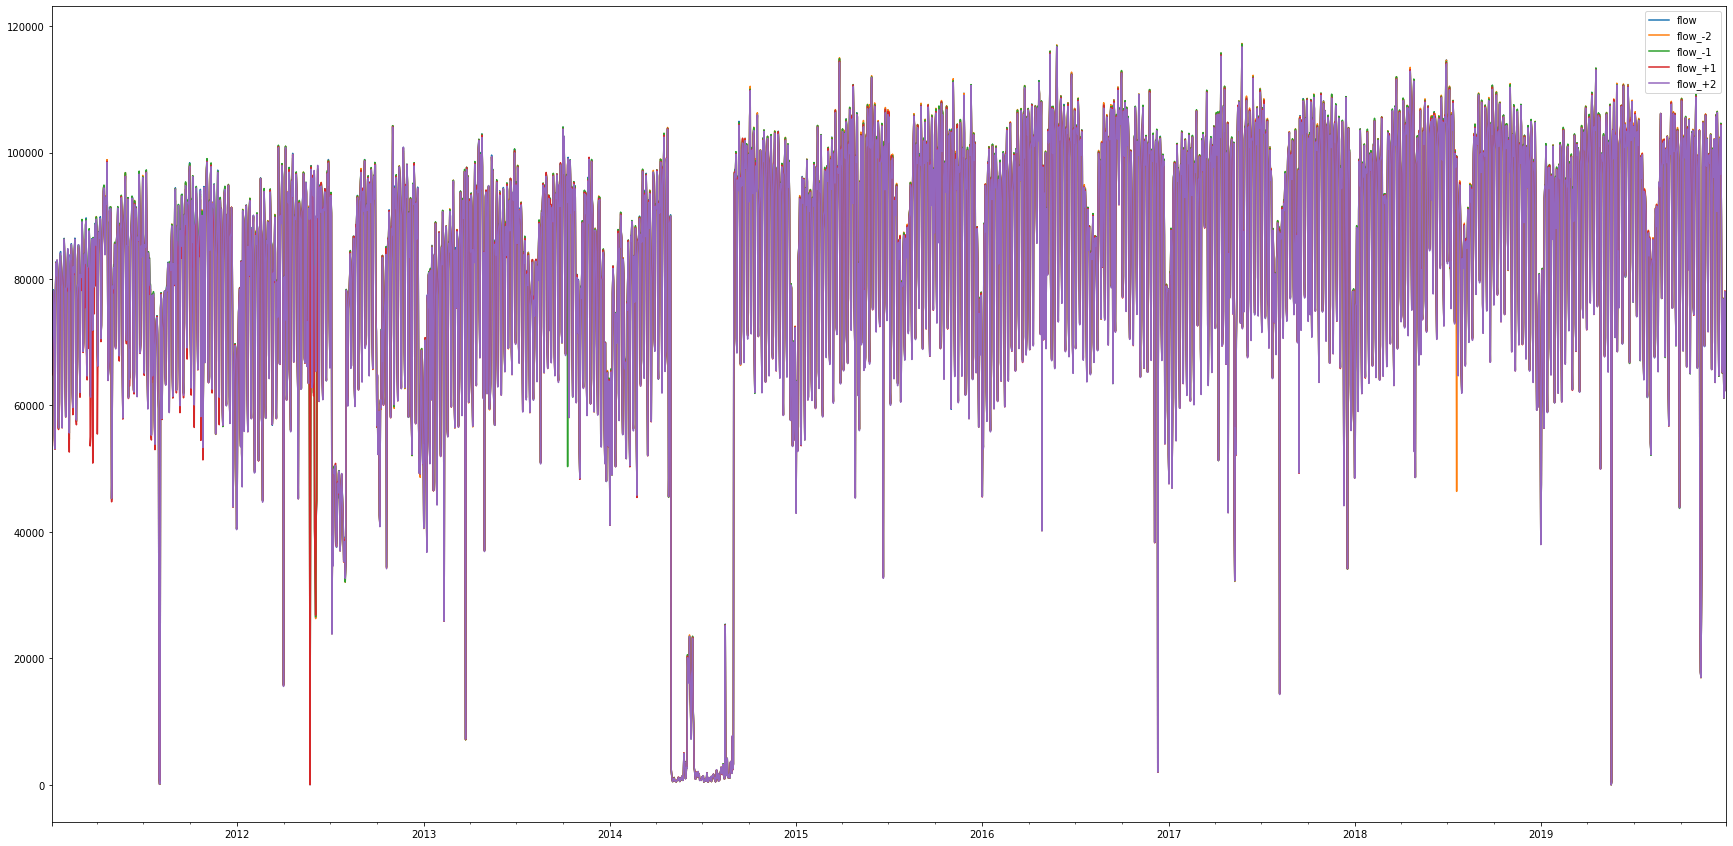

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,15))
    df[speed_cols].plot(ax = ax)

In [0]:
# Interpolate null vals for the first week of data of speed and flow cols
def interpolate_week(df, cols):
    week = 7 * 24 * 60
    for col in cols: 
        df.iloc[:week, df.columns.get_loc(col)] = df[col][:week].interpolate(method = 'time')


# Replace remaining nulls with value from 1 week previous
def shift_week(df, cols):
    # Return to RangeIndex for the next operation
    df.reset_index(drop = True, inplace = True)
    week = 7 * 24 * 60
    for col in cols:
        col_index = df.columns.get_loc(col)
        for row in df.itertuples():
            if np.isnan(row[col_index]):
                df.iat[row[0], col_index] = df.iat[(row[0] - week), col_index]
    # Return to DateTimeIndex again
    df.set_index(pd.DatetimeIndex(df.index.values), inplace = True) 
    return df

df_2 = interpolate_week(df, cols[:-1])
df_2 = shift_week(df, cols[:-1])

In [68]:
df3 = resample_df(df_2, freq = "D", method_speed = np.mean, method_flow = np.sum)

TypeError: ignored

In [0]:
fig, ax = plt.subplots(figsize = (30,15))
    plot_df[plot_cols].plot(ax = ax)

In [72]:
df_2.set_index(pd.DatetimeIndex(df_2.index.values), inplace = True) 
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4727520 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.004727519
Data columns (total 11 columns):
speed          float64
speed_-2       float64
speed_-1       float64
speed_+1       float64
speed_+2       float64
flow           float64
flow_-2        float64
flow_-1        float64
flow_+1        float64
flow_+2        float64
speed_limit    float64
dtypes: float64(11)
memory usage: 432.8 MB


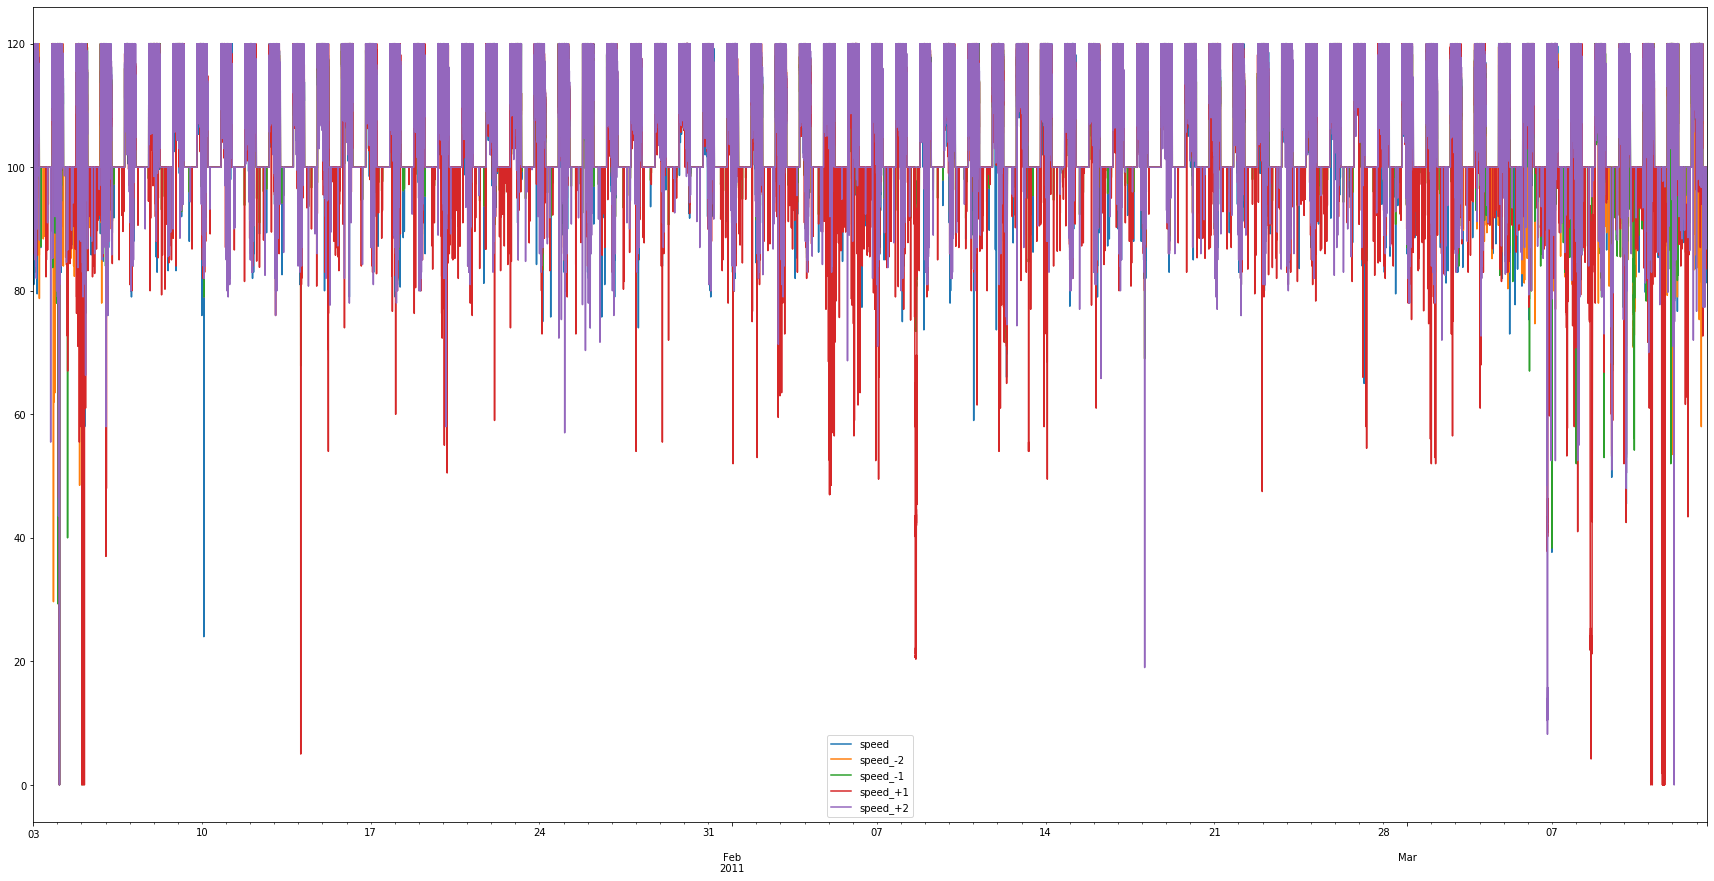

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,15))
df_imputed[:100000][speed_cols].plot(ax = ax)

In [0]:
import numpy as np
test = df_imputed.resample("W").agg({"speed": np.mean, "speed_-2": np.mean, "speed_-1": np.mean, "speed_+1": np.mean, "speed_+2": np.mean,
                             "flow": np.sum, "flow_-2": np.sum, "flow_-1": np.sum, "flow_+1": np.sum, "flow_+2": np.sum})

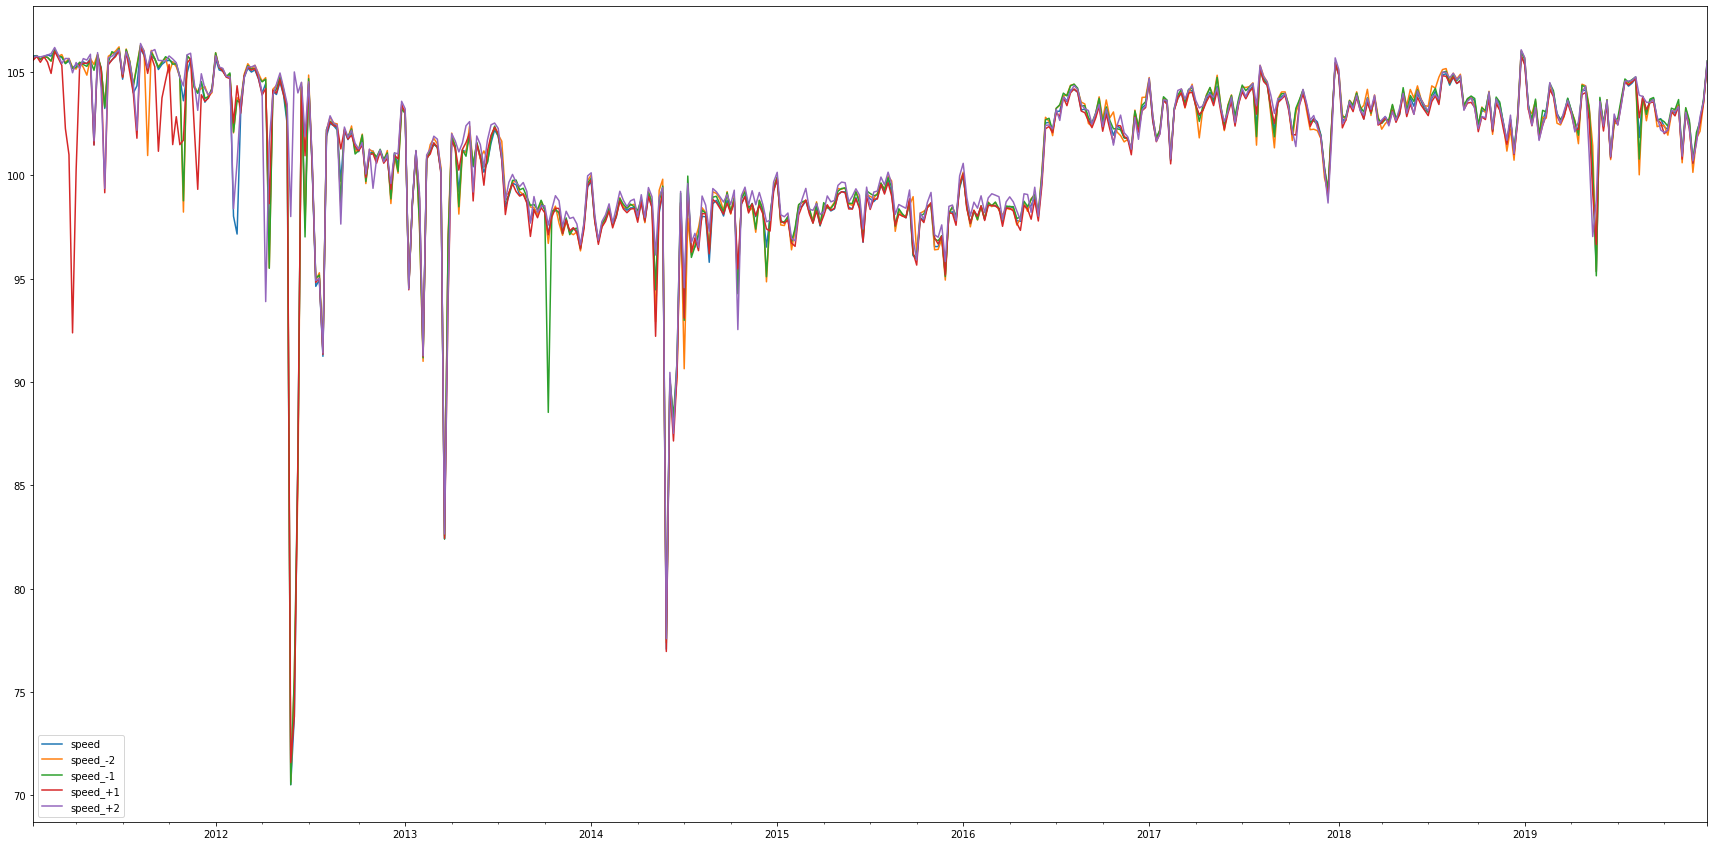

In [0]:
pd.options.display.max_rows = 1000
pd.options.display.float_format = "{:.2f}".format
test

In [0]:
df.head(500)

In [0]:
df.loc[df.isnull().any(axis=1)]

    Number of records:      4,727,520
    Number of null records:   288,548
    ---------------------------------
    Null ratio:                 0.061    


In [0]:
import numpy as np
temp = pd.DataFrame()
df = df.assign(reference_speed = df.speed.interpolate(method = "time"))
df = df.assign(missing = np.nan)
df.missing[df.isnull().any(axis=1)] = df.reference_speed

,speed,flow,speed_RWS01_MONIBAS_0021hrl0403ra,flow_RWS01_MONIBAS_0021hrl0403ra,speed_RWS01_MONIBAS_0021hrl0409ra,flow_RWS01_MONIBAS_0021hrl0409ra,speed_RWS01_MONIBAS_0021hrl0420ra,flow_RWS01_MONIBAS_0021hrl0420ra,speed_RWS01_MONIBAS_0021hrl0426ra,flow_RWS01_MONIBAS_0021hrl0426ra,speed_limit,reference_speed,missing
2011-01-03 00:00:00,120.000000,8.0,100.000000,8.0,120.000000,6.0,118.5,4.0,120.000000,6.0,120.0,120.000000,120.000000
2011-01-03 00:01:00,120.000000,5.0,115.000000,18.0,120.000000,6.0,118.0,5.0,104.000000,2.0,120.0,120.000000,120.000000
2011-01-03 00:02:00,111.000000,2.0,112.666667,14.0,104.000000,2.0,91.0,4.0,112.666667,8.0,120.0,111.000000,111.000000
2011-01-03 00:03:00,105.333333,10.0,118.000000,14.0,108.666667,6.0,120.0,9.0,120.000000,10.0,120.0,105.333333,105.333333
2011-01-03 00:04:00,120.000000,8.0,105.500000,21.0,120.000000,13.0,120.0,7.0,117.500000,5.0,120.0,120.000000,120.000000


In [0]:
# Fill in the null vals for reference
df = df.assign(reference_speed = dfspeed.interpolate(method = "time"))
# Add a col with interpolated values in the missing values position (the rest null) for plotting
df = dfassign(missing = np.nan)
dfmissing[df.isnull().any(axis=1) = august.reference_speed

# Plot it (red are missing)
august[["speed", "missing"]].plot(style = ["b.", "rx"], figsize = (16, 9), alpha = 0.6, title = "August")
sns.despine()
plt.tight_layout()
plt.savefig(plotdir + "August.png")


# Luckily they are not all clumped, so the interpolation should be smooth

# Now drop unnecessary speed col
august.drop("speed", axis = 1, inplace = True)

# There are no null vals left since we already interpolated reference_speed.
august["reference_speed"].isnull().any()

# Randomly null out 10% of the values in a new col target_speed that we want to test interpolation methods on
august["target_speed"] = august["reference_speed"].mask(np.random.choice([True, False], size=august["reference_speed"].shape, p = [.1,.9]))

# We now have thousands of null vals
august["target_speed"].isna().sum()

# Make a new column with only the reference values that aren"t in the target col, like earlier but with the larger
# set of randomly removed values
august = august.assign(missing = np.nan)
august.missing[august.target_speed.isna()] = august.reference_speed
august.info()

# Plot it (red are missing)
august[["target_speed", "missing"]].plot(style=["b.", "rx"], figsize=(16, 9), alpha = 0.6, title = "August /w 10% data removed")

In [0]:
pd.set_option("display.max_rows", 500)
df.speed[df.speed.notna()].astype(int).value_counts().head(25)

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,12))
df.speed[(df.speed.notna()) & (df.speed > 70)].hist(bins = 50, grid = False)

In [0]:
df2 = df.resample("M").agg({"speed": np.mean, "flow": np.sum})

In [0]:
plt.figure(figsize=(20,10))
plt.scatter(df.index, df.speed)

In [0]:
def missing_per_month(df):
    df["null"] = np.where(df.speed.isna(), 1, np.nan)
    df["timestamp"] = df.index
    df.groupby(pd.Grouper(key="timestamp", freq="M"))["null"].sum()
missing_per_month(df)

In [0]:
fig, ax = plt.subplots(figsize = (40,30))
df[['null']].plot(ax = ax, alpha = 0.5)